In [1]:
%matplotlib inline

#
# import utilitaires
#
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns

import helpers as hlp
import helpers.dataset.PlantVillage as pv
import helpers.features as feat
import helpers.split as split

In [2]:
#
# parametres
#
configs = hlp.get_configs("config_overrides.json")

#
# dataset PlantVillage
#
pv_dataset = pv.load(configs.plant_village)
pv_dataframe = pv_dataset.dataframe

print("Dataset", pv_dataframe.shape)


#
# train/test
#
train, _ = split.load(configs.split)
pv_train = pv_dataframe.loc[train, ["label"]]

print("Train size:", len(train))

#
# orb
#
orb_features = feat.load(configs.orb, None)

print("ORB features:", orb_features.features.shape)


#
# sift
#
sift_features = feat.load(configs.sift, None)

print("Sift features:", sift_features.features.shape)

Dataset (60343, 5)
Train size: 3711
ORB features: (20908751, 32)
Sift features: (14386568, 128)


In [3]:
def key_points_orb_vs_sift(image_indices):
    orb_num_kpts = []
    sift_num_kpts = []

    for image_index in image_indices:
        image_index_str = str(image_index)

        orb_num_kpt = orb_features.index_to_key_points[image_index_str].shape[0]
        sift_num_kpt = sift_features.index_to_key_points[image_index_str].shape[0]
        
        orb_num_kpts.append(orb_num_kpt)
        sift_num_kpts.append(sift_num_kpt)
        
    return np.array(orb_num_kpts), np.array(sift_num_kpts)
        
num_orb_kp, num_sift_kp = key_points_orb_vs_sift(train)

pv_train["ORB_kp_count"] = num_orb_kp
pv_train["SIFT_kp_count"] = num_sift_kp

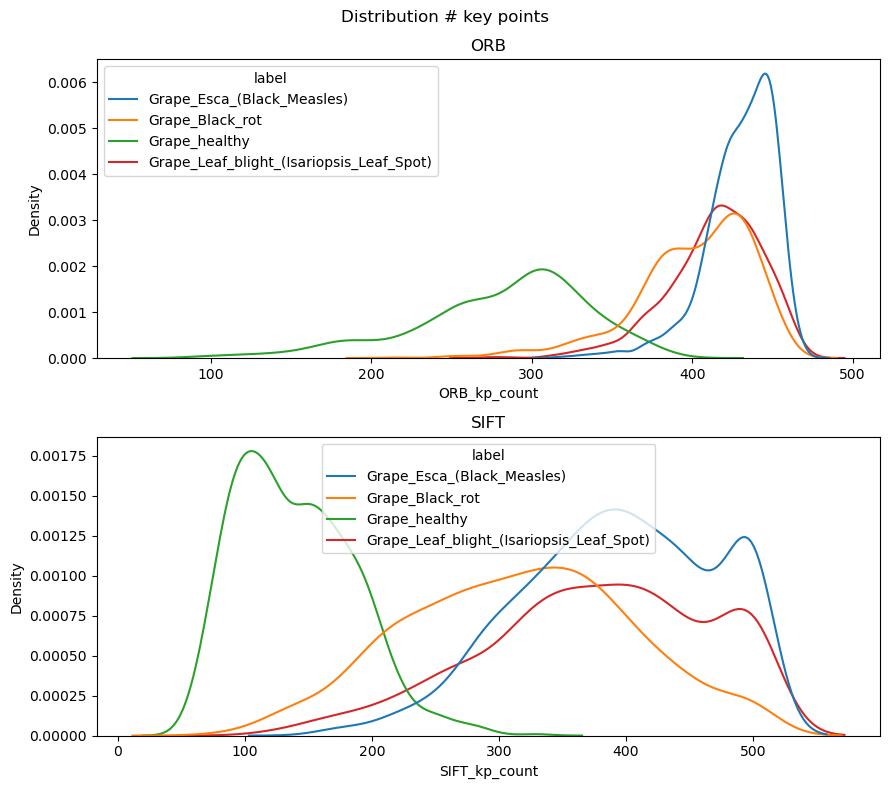

In [4]:
plt.figure(figsize=(9, 8))

plt.subplot(211)
sns.kdeplot(x="ORB_kp_count", data=pv_train, hue="label", ax=plt.gca())
plt.title("ORB")

plt.subplot(212)
sns.kdeplot(x="SIFT_kp_count", data=pv_train, hue="label", ax=plt.gca())
plt.title("SIFT")

plt.suptitle("Distribution # key points")
plt.tight_layout()
plt.show()

Grape_healthy a clairement moins de keypoints en général. Les autres labels ont relativement la meme densité de keypoints sauf pour ORB. Aussi, ORB semble avoir en général plus de keypoints que SIFT. On se serait attendu donc a avoir un pouvoir discriminant un peu meilleur que ce que suggère les tests précedants.

Les labels Grape_Black_rot et Grape_Esca_(Black_Measles) sont problématiques pour Random Forest alors que Grape_healthy et Grape_Black_rot le sont pour KNN. Le pouvoir discriminant des features est donc problematique. Une visualisation permettra de mieux comprendre.

**Reviser ca**; je veux aboutir sur la distribution spatiale dans l'image.

In [5]:
# doit etre pair
SAMPLES_COUNT = 14
SAMPLES_GRID = (SAMPLES_COUNT // 2, 4)
FIGSIZE = (10, SAMPLES_GRID[0] * 2.5)

def orb_vs_sift(title_prefix, indices):
    # selectionner quelques images aleatoirement
    random.seed(33) # # doit etre pair
SAMPLES_COUNT = 14
SAMPLES_GRID = (SAMPLES_COUNT // 2, 4)
FIGSIZE = (10, SAMPLES_GRID[0] * 2.5)

def orb_vs_sift(title_prefix, indices):
    # selectionner quelques images aleatoirement
    random.seed(75) # 33
    image_indices = random.choices(indices, k=SAMPLES_COUNT)
    image_indices.sort()

    figure, axes = plt.subplots(SAMPLES_GRID[0],
                                SAMPLES_GRID[1],
                                figsize=FIGSIZE)
    
    axes_flatten = axes.flatten()

    for i, image_index in enumerate(image_indices):
        image = pv_dataset.get_image(image_index)
        
        image_index_str = str(image_index)
        key_points_a = orb_features.index_to_key_points[image_index_str][...]
        key_points_b = sift_features.index_to_key_points[image_index_str][...]
        
        image_key_points_a = feat.draw_key_points(image, key_points_a)
        image_key_points_b = feat.draw_key_points(image, key_points_b)

        species, disease = pv_dataframe.loc[image_index, ["species", "disease"]]
        disease = pv.attribute_prettify(species, disease)
        disease = disease.replace("\n", " ")
        title = "\n".join([species, disease])
        
        plt.sca(axes_flatten[i * 2 + 0])
        plt.gca().set_xlabel(len(key_points_a))
        plt.gca().set_ylabel(title)
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])
        plt.imshow(image_key_points_a)
        
        plt.sca(axes_flatten[i * 2 + 1])
        plt.gca().set_xlabel(len(key_points_b))
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])
        plt.imshow(image_key_points_b)

    axes[0, 0].set_title("ORB")
    axes[0, 1].set_title("SIFT")
    axes[0, 2].set_title("ORB")
    axes[0, 3].set_title("SIFT")
    
    plt.suptitle(f"{title_prefix} - ORB vs SIFT")
    plt.tight_layout()
    plt.show()

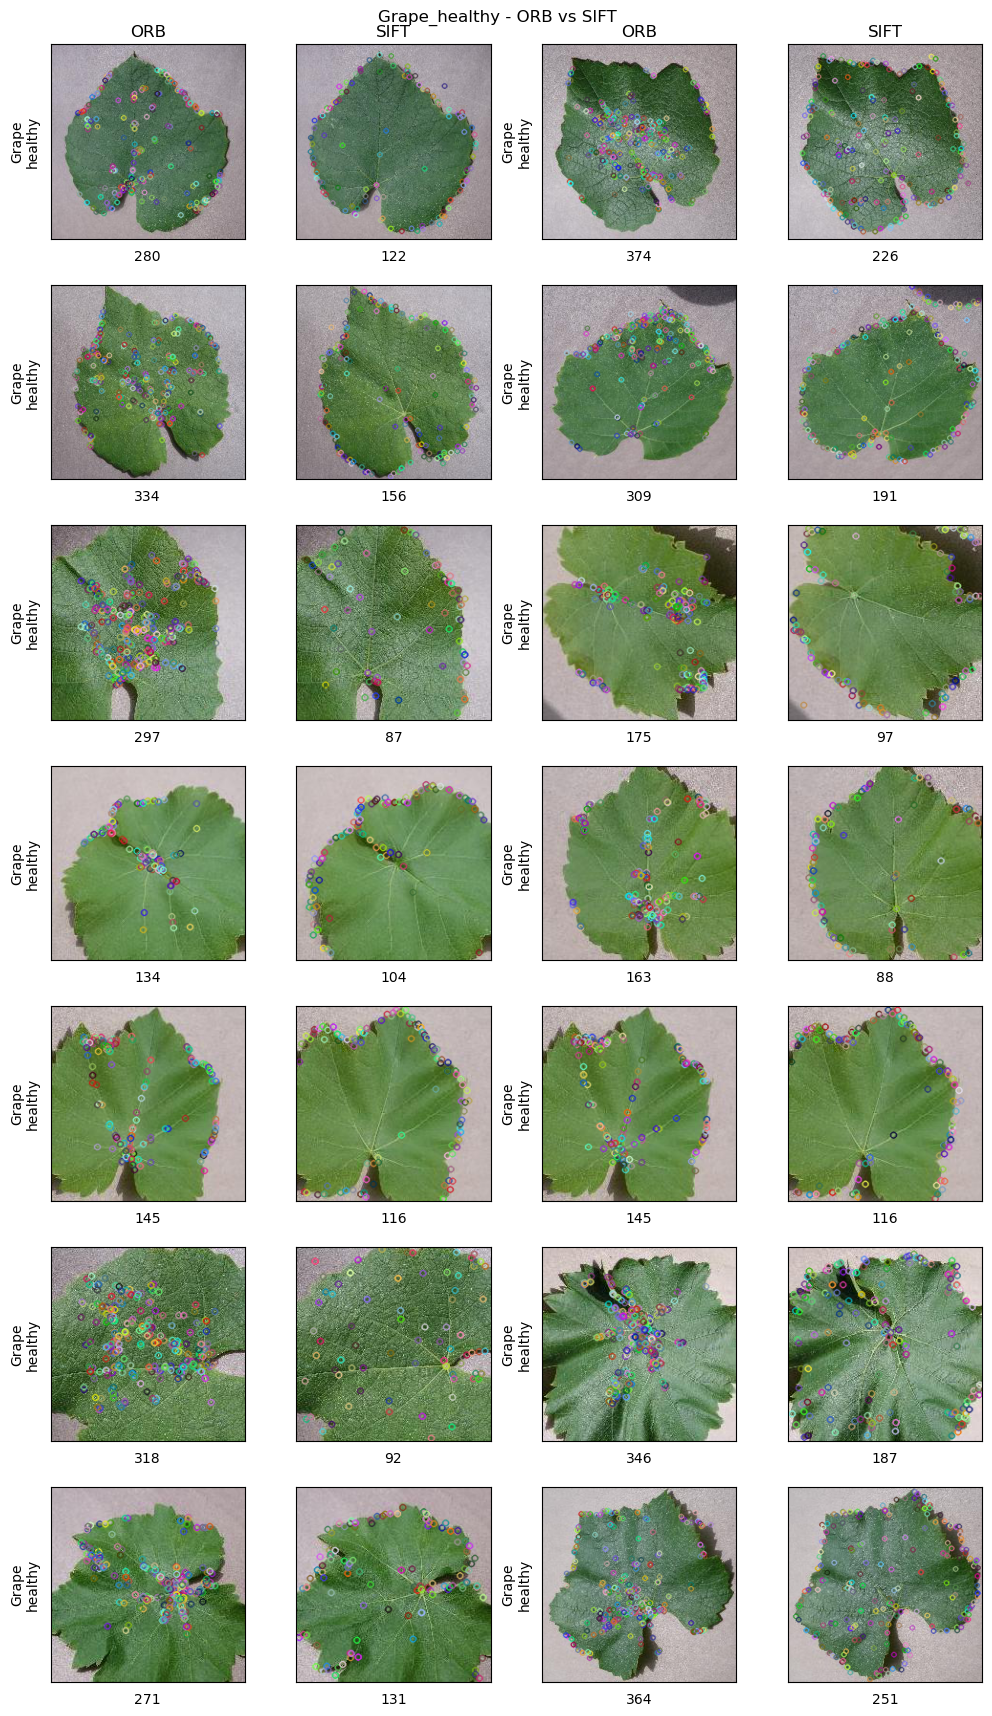

In [6]:
pv_train_healthy = pv_train[ pv_train["label"].str.contains("Grape_healthy")  ].index.values
orb_vs_sift("Grape_healthy", pv_train_healthy)

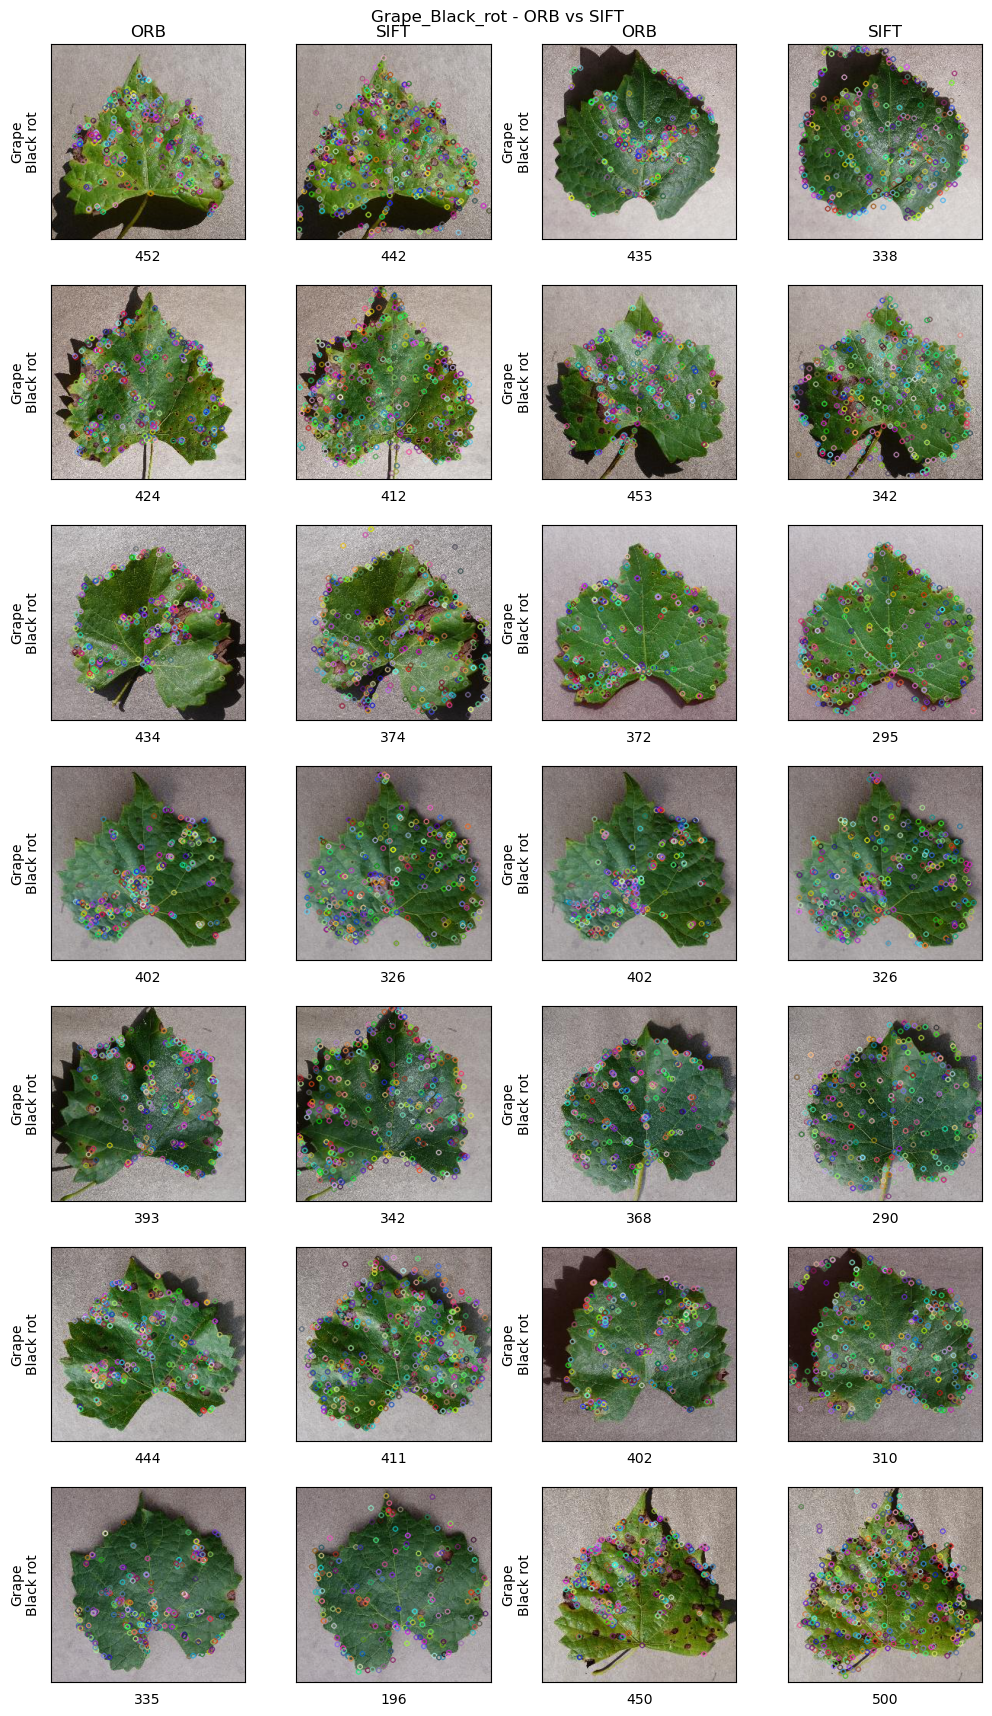

In [7]:
pv_train_black_rot = pv_train[ pv_train["label"].str.contains("Grape_Black_rot")  ].index.values
orb_vs_sift("Grape_Black_rot", pv_train_black_rot)

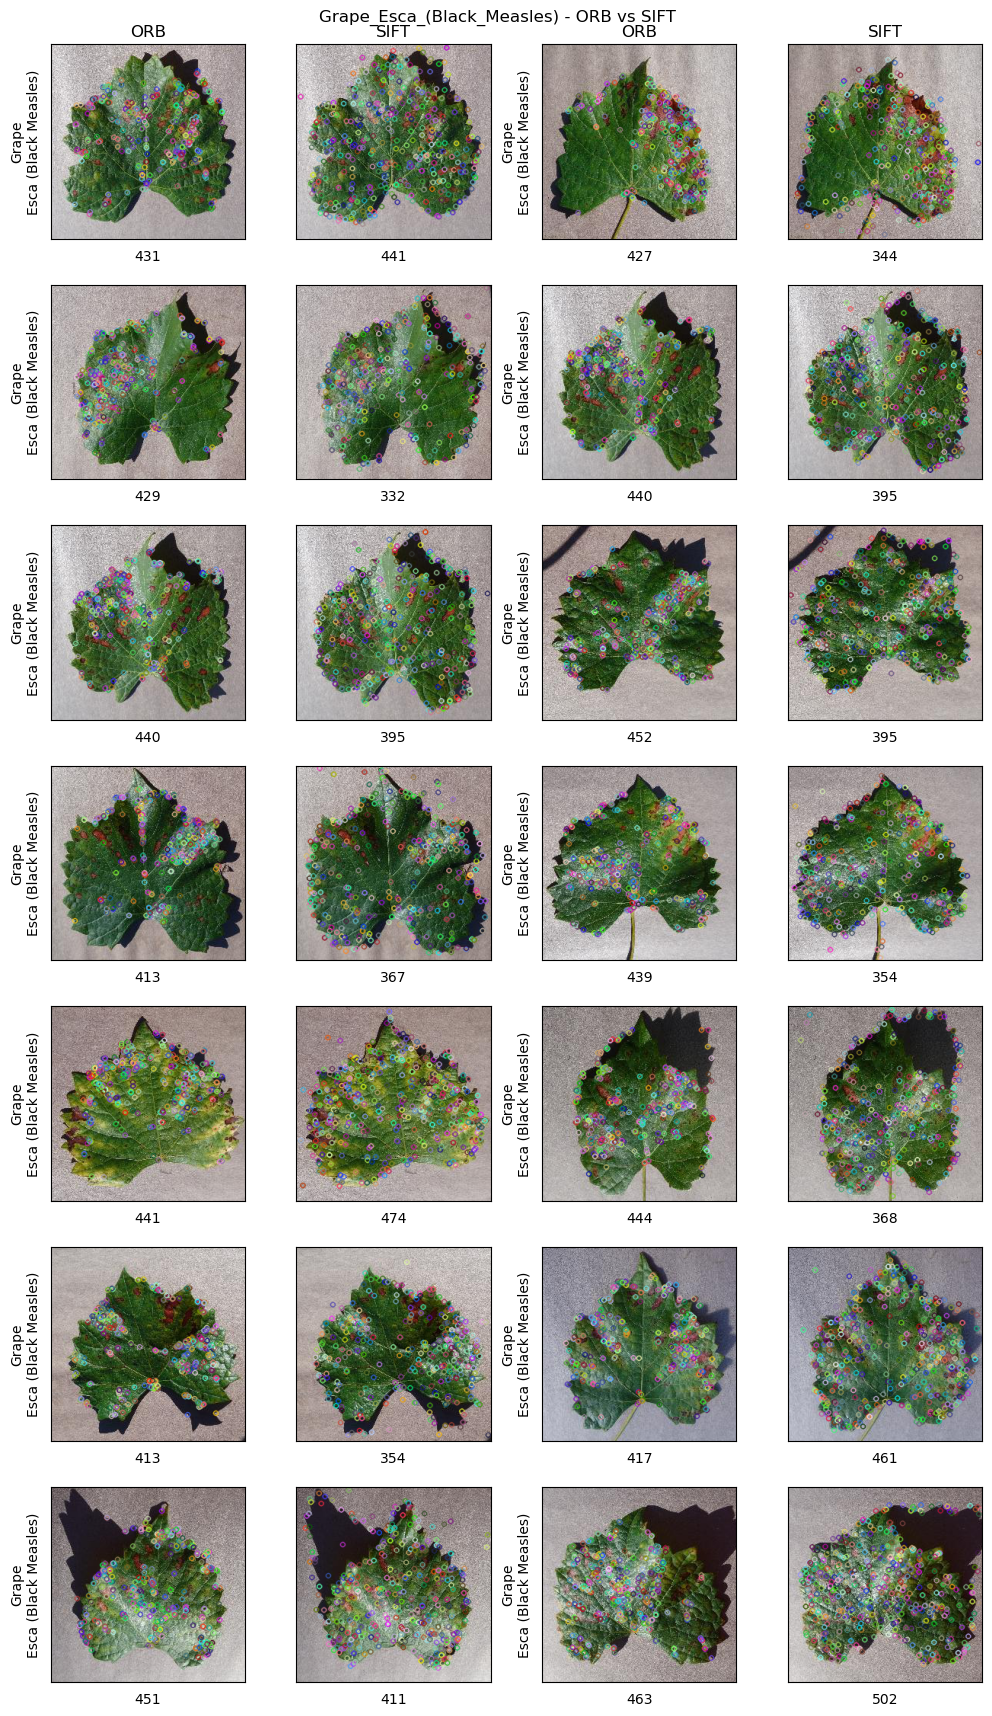

In [8]:
pv_train_cruciatus_curse = pv_train[ pv_train["label"].str.contains("Grape_Esca_\(Black_Measles\)")  ].index.values
orb_vs_sift("Grape_Esca_(Black_Measles)", pv_train_cruciatus_curse)

On voit bien que les key points ORB ne couvrent pas bien les zones texturées ni la silhouette de la feuille. SIFT s'en tire mieux avec la silhouette mais pourrait faire mieux dans les zones texturées. Ceci pourrait epxliquer le manque de pouvoir discriminant des features.

Prochaine etape est de tiler les images pour assurer une meilleure couverture des features.